# **Experiment Tracking with Weights and Biases (W&B)**

In [3]:
from diffusers import UNet2DModel

import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
import numpy as np
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [4]:
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## **Load Data**

For this notebook, we will be working with:
- [CIFAR10](https://paperswithcode.com/dataset/cifar-10) dataset, which is a step up in complexity when compared to Fashion MNIST and is usually considered as the smallest dataset in alot of generative and CV research.
- [Weights and Biases](https://wandb.ai) for experiment tracking.

In [5]:
xl, yl = 'img', 'label'
name = "cifar10"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o)-0.5 for o in b[xl]]

bs = 32
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
# Training data loader with xb and yb
dt = dls.train
xb, yb = next(iter(dt))

In [9]:
xb.shape

torch.Size([32, 3, 32, 32])

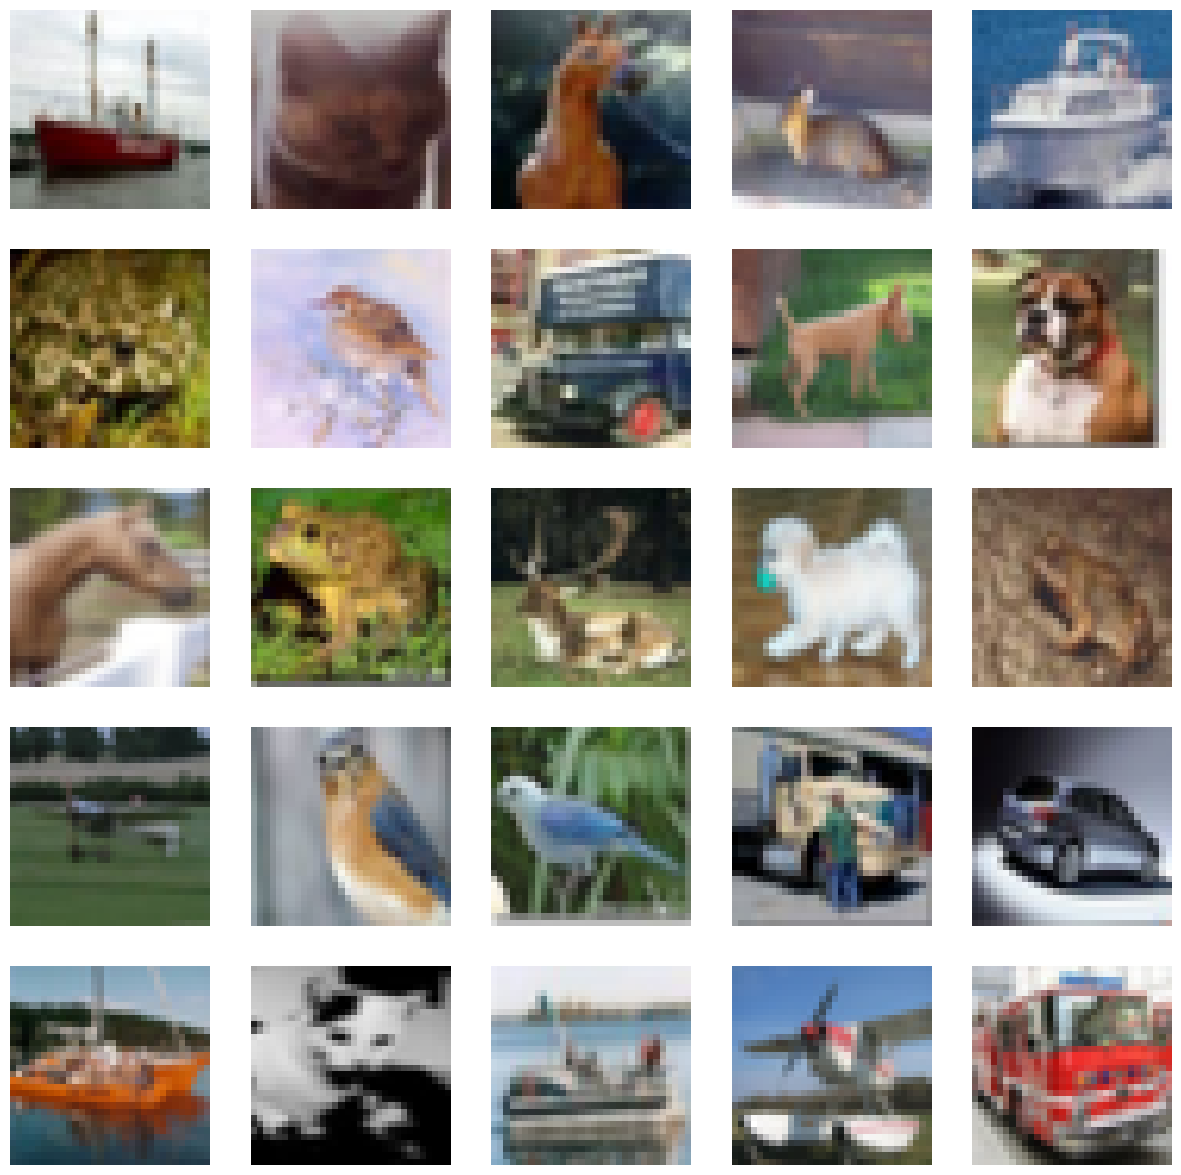

In [15]:
# Show images in batch
# Adding 0.5 fixes brightness problems
show_images(xb[:25]+0.5)

In [16]:
from types import SimpleNamespace

def linear_sched(beta_min=0.0001, beta_max=0.02, n_steps=1000):
    beta = torch.linspace(beta_min, beta_max, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [17]:
n_steps = 1000
lin_abar = linear_sched(beta_max=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [18]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [19]:
(xt, t), ε = noisify(xb[:25], alphabar)
t

tensor([664,  97,  54, 255, 234, 712, 872, 321, 354, 631, 589, 977, 261, 468,
        363, 555, 742, 199, 188, 371, 645, 439, 322, 980, 473])

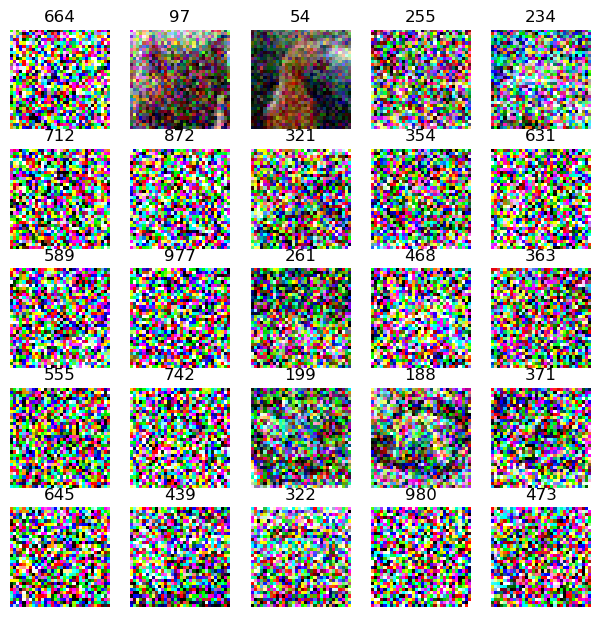

In [20]:
# Visualizing noisified images
titles = fc.map_ex(t[:25], '{}')
show_images(xt[:25].clip(-0.5, 0.5) + 0.5, imsize=1.5, titles=titles)